In [1]:
import sys
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/")
sys.path.append("/Users/skrishna/Documents/phd_codes/neurips_paper/")
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/AR")
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/Generative_Model")


sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/AR/recourse/")



In [2]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn as nn
import pickle as pkl
from numpy import linalg as LA
import torch.nn as nn

import ML_Models.data_loader as loader
# from utils import _get_input_subset
# from Recourse_Methods.gradient_methods import SCFE
# from utils import get_recourses, get_performance_measures


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
## Dataset Prep


from torchvision import  datasets, transforms
from torch.utils.data import DataLoader

# data_name = "compas"
data_name = "adult"
# data_name = "german"
n_starting_instances = 1200
compas_dict = {
        "data_path": '../Data_Sets/COMPAS/',
        "filename_train": 'compas-train-upsampled.csv',
        "filename_test": 'compas-test-upsampled.csv',
        "label": "risk",
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 10,
        "H2": 10,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    }

german_dict = {
        "data_path": '../Data_Sets/German_Credit_Data/',
        "filename_train": 'german-train.csv',
        "filename_test": 'german-test.csv',
        "label": "credit-risk",
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 10,
        "H2": 10,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    
    }

adult_dict = {
        "data_path": "../Data_Sets/Adult/",
        "filename_train": 'adult-train.csv',
        "filename_test": 'adult-test.csv',
        "label": 'income',
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 25,
        "H2": 25,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    }


data_meta_dictionaries = {
        "compas": compas_dict, 
        "adult": adult_dict, 
        "german":german_dict
    }
data_meta_info = data_meta_dictionaries[data_name]


dataset_test = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                 filename=data_meta_info["filename_test"],
                                                 label=data_meta_info["label"], scale = "standard")
        
dataset_train = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                  filename=data_meta_info["filename_train"],
                                                  label=data_meta_info["label"], scale = "standard")


column_names = pd.read_csv(data_meta_info["data_path"] + data_meta_info["filename_train"]).drop(data_meta_info["label"], axis=1).columns



In [4]:
# Data loader

train_loader = DataLoader(dataset_train, batch_size = 1, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size = 1, shuffle=False)

data = [i for i in train_loader]
num_input = len(data[0][0][0])



In [5]:
len(data)

36177

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

# do a single pass over the data
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y, ind in loader:
        yp = model(X.view(X.shape[0], -1).to(torch.float32))[:,0]
#         y_class = torch.tensor((yp > 0)).to(torch.int32) # * (y==0) + (yp < 0) * (y==1)).sum().item()
#         print("F1-Score : ", f1_score(y_class.numpy(), y.numpy()))
#         print(yp)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        
        
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

model = nn.Linear(num_input, 1)
opt = optim.SGD(model.parameters(), lr=1e-3)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
test_errs = []
for i in range(80):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    test_errs.append(test_err)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

    

Train Err	Train Loss	Test Err	Test Loss
0.182436	0.391236	0.170149	0.355734
0.163585	0.347543	0.167385	0.348234
0.160710	0.343205	0.165948	0.345285
0.159521	0.341431	0.164621	0.343561
0.159024	0.340475	0.163295	0.342860
0.158664	0.339813	0.163516	0.342530
0.159494	0.339680	0.162742	0.341992
0.159355	0.339455	0.164069	0.341964
0.159494	0.339314	0.162521	0.342044
0.159051	0.339258	0.163737	0.341384
0.159825	0.339220	0.162852	0.341629
0.159051	0.339154	0.162300	0.342192
0.159051	0.339225	0.163074	0.341602
0.159107	0.339174	0.162742	0.341203
0.158333	0.339017	0.164511	0.341461
0.159162	0.339212	0.163405	0.341486
0.158941	0.339080	0.161857	0.341590
0.159024	0.339046	0.163626	0.341382
0.158858	0.339091	0.163405	0.341796
0.159438	0.339195	0.162189	0.341606
0.159134	0.339207	0.164069	0.341251
0.158664	0.339112	0.164953	0.341265
0.159383	0.339256	0.163405	0.341333
0.158941	0.339067	0.163626	0.341597
0.159272	0.339075	0.162963	0.341706
0.159024	0.339123	0.162852	0.341218
0.159051	0.339133	0.1646

In [7]:
torch.save(model, "./models/{}_ann_model.pth".format(data_name))






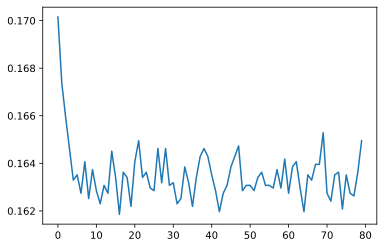

In [8]:
plt.plot(range(len(test_errs)), test_errs)

In [9]:
epsilon = 0.5
delta = epsilon * model.weight.detach().sign()

# Testing error on adversarial sample 
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        X = X.to(torch.float32)
#         tmp = ((2*y.float()-1)[:, None]*delta.squeeze(0)).squeeze(0)
        yp = model(X-((2*y.float()-1)[:, None]*delta.squeeze(0)).squeeze(0)).squeeze(-1)
#         print(yp)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.6904367053620785, 1.8712859421706414)


In [10]:
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        yp = model(X.view(X.shape[0], -1).to(torch.float32))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


model_robust = nn.Linear(num_input, 1)
opt = optim.SGD(model_robust.parameters(), lr=1e-3)
epsilon = 0.5
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(30):
    train_err, train_loss = epoch_robust(train_loader, model_robust, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model_robust, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")    

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.262211	0.576371	0.247872	0.562053
0.247837	0.561349	0.247872	0.561702
0.247837	0.561374	0.247872	0.560639
0.247837	0.561377	0.247872	0.561331
0.247837	0.561342	0.247872	0.560589
0.247837	0.561374	0.247872	0.561384
0.247837	0.561334	0.247872	0.561046
0.247837	0.561356	0.247872	0.560946
0.247837	0.561351	0.247872	0.561371
0.247837	0.561332	0.247872	0.561491
0.247837	0.561357	0.247872	0.560840
0.247837	0.561324	0.247872	0.560807
0.247837	0.561335	0.247872	0.562319
0.247837	0.561355	0.247872	0.561529
0.247837	0.561361	0.247872	0.563019
0.247837	0.561356	0.247872	0.560964
0.247837	0.561361	0.247872	0.561721
0.247837	0.561378	0.247872	0.561859
0.247837	0.561364	0.247872	0.560960
0.247837	0.561371	0.247872	0.560728


KeyboardInterrupt: 

In [ ]:
# model = torch.load("./models/{}_lr_model.pth".format(data_name))
torch.save(model_robust, "./models/{}_ann_model.pth".format(data_name))


In [ ]:
data_name

In [ ]:
# Recourse Method 2
import Recourse_Methods.Generative_Model.model as model_vae
from numpy import linalg as LA

# Second class of counter-factual explanation methods         
class CCHVAE:

    def __init__(self, classifier, model_vae, target_threshold: float = 0,
                 n_search_samples: int = 10000, p_norm: int = 1,
                 step: float = 0.05, max_iter: int = 1000, clamp: bool = True):
        
        super().__init__()
        self.classifier = classifier
        self.generative_model = model_vae
        self.n_search_samples = n_search_samples
        self.p_norm = p_norm
        self.step = step
        self.max_iter = max_iter
        self.clamp = clamp
        self.target_treshold = target_threshold

    def hyper_sphere_coordindates(self, instance, high, low):
    
        """
        :param n_search_samples: int > 0
        :param instance: numpy input point array
        :param high: float>= 0, h>l; upper bound
        :param low: float>= 0, l<h; lower bound
        :param p: float>= 1; norm
        :return: candidate counterfactuals & distances
        """
    
        delta_instance = np.random.randn(self.n_search_samples, instance.shape[1])
        dist = np.random.rand(self.n_search_samples) * (high - low) + low  # length range [l, h)
        norm_p = LA.norm(delta_instance, ord=self.p_norm, axis=1)
        d_norm = np.divide(dist, norm_p).reshape(-1, 1)  # rescale/normalize factor
        delta_instance = np.multiply(delta_instance, d_norm)
        candidate_counterfactuals = instance + delta_instance
    
        return candidate_counterfactuals, dist

    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: int = 1) -> torch.tensor:
        """
        :param instance: np array
        :return: best CE
        """  #

        # init step size for growing the sphere
        low = 0
        high = low + self.step

        # counter
        count = 0
        counter_step = 1
        query_instance = query_instance.detach().numpy()

        # get predicted label of instance
        self.classifier.eval()
        instance_label = 1 - target_class
        # vectorize z
        z = self.generative_model.encode_csearch(torch.from_numpy(query_instance).float()).detach().numpy()
        z_rep = np.repeat(z.reshape(1, -1), self.n_search_samples, axis=0)

        while True:
            count = count + counter_step
            if count > self.max_iter:
                candidate_counterfactual_star = np.empty(query_instance.shape[0], )
                candidate_counterfactual_star[:] = np.nan
                distance_star = -1
                print('No CE found')
                break

            # STEP 1 -- SAMPLE POINTS on hypersphere around instance
            latent_neighbourhood, _ = CCHVAE.hyper_sphere_coordindates(self, z_rep, high, low)
            
#             print("-->> ", latent_neighbourhood)
            x_ce = self.generative_model.decode_csearch(torch.from_numpy(latent_neighbourhood).float()).detach().numpy()
            
            
            # why do we have this?
#             if self.clamp:
#                 x_ce = x_ce.clip(-1, 1)

            # STEP 2 -- COMPUTE l1 & l2 norms
            if self.p_norm == 1:
                distances = np.abs((x_ce - query_instance)).sum(axis=1)
            elif self.p_norm == 2:
                distances = LA.norm(x_ce - query_instance, axis=1)
            else:
                print('Distance not defined yet')
            
            # counterfactual labels
#             print(self.classifier(torch.from_numpy(x_ce).float()).detach().numpy())
            y_candidate = torch.stack([torch.tensor([int(i[0])]) for i in self.classifier(torch.from_numpy(x_ce).float()).detach().numpy() > 0])
#             print("Y_Cands : ", self.classifier(torch.from_numpy(x_ce).float()).detach().numpy())
            indeces = np.where(y_candidate != instance_label)[0]
#             print("Indeces : ", indeces)
            candidate_counterfactuals = x_ce[indeces]
            candidate_dist = distances[indeces]
            
            if len(candidate_dist) == 0:  # no candidate found & push search range outside
                low = high
                high = low + self.step
            elif len(candidate_dist) > 0:  # certain candidates generated
                min_index = np.argmin(candidate_dist)
                candidate_counterfactual_star = candidate_counterfactuals[min_index]
                distance_star = np.abs(candidate_counterfactual_star - query_instance).sum()
                break

#         return torch.tensor(candidate_counterfactual_star), torch.tensor(distance_star)
        return  torch.tensor(distance_star)     
    
    
    

In [ ]:
def _get_input_subset(model_sub, inputs: torch.tensor,
                      subset_size: int = 100,
                      decision_threshold: float = 0) -> torch.tensor:
    
    """
    Get negatively classified inputs & return their predictions
    """
    
    yhat = (model_sub(inputs) > decision_threshold) * 1
    print(model_sub(inputs))
    check = (model_sub(inputs) < decision_threshold).detach().numpy()
    selected_indices = np.where(check)[0]
    input_subset = inputs[selected_indices]
    predicted_label_subset = yhat[selected_indices]
    return input_subset, predicted_label_subset #[0:subset_size] #[0:subset_size]

In [ ]:
# Load the VAEs

vae_path = "../Recourse_Methods/Generative_Model/Saved_Models/"

input_size = dataset_train.get_number_of_features()

vae_model = model_vae.VAE_model(input_size,
                                data_meta_info['activFun'],
                                data_meta_info['d'],
                                data_meta_info['H1'],
                                data_meta_info['H2'])

data_meta_info["vae_path"] = vae_path + f"vae_{data_name}.pt"
print(data_meta_info["vae_path"])

vae_model.load_state_dict(torch.load(data_meta_info["vae_path"]))
        
testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=True)
        
trainloader = DataLoader(dataset_train,
                         batch_size=data_meta_info["n_starting_instances"],
                         shuffle=True)


# This method makes the "Manifold assumption" and uses random search in latent space
cchvae = CCHVAE(classifier=model, model_vae=vae_model, step=0.5, max_iter=10000, target_threshold=0)
cchvae_r = CCHVAE(classifier=model_robust, model_vae=vae_model, step=109.5, max_iter=10000, target_threshold=0)

# cchvae = CCHVAE(classifier=model, model_vae=vae_model, step=0.01, max_iter=10000, target_threshold=0)
# cchvae2 = CCHVAE(classifier=model_robust, model_vae=vae_model, step=0.01, max_iter=10000, target_threshold=0)

### Plot 1 : Box plot for baseline and robust models for distance, and validity. 

# inputs = torch.stack([j for i in test_loader for j in torch.unbind(i[0].to(torch.float32))][:200])






In [ ]:
cchvae_r = CCHVAE(classifier=model_robust, model_vae=vae_model, step=1.5, max_iter=10000, target_threshold=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
subset_size = 1
testloader = DataLoader(dataset_train,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model_robust, inputs, subset_size, decision_threshold=0)
print(inputs.shape)
print(inputs[0].reshape(1, -1))

distances_cchave_r = []
for i in range(len(inputs)):
    if i%10 == 0:
        print("Gotten {} done...".format(i))
    ctr_val = cchvae_r.generate_counterfactuals(
                    query_instance= inputs[i].reshape(1, -1),
                    target_class= 1 ).item()
    if ctr_val > 0:
        distances_cchave_r.append(ctr_val)
        
        

In [60]:
len(inputs)

1

In [44]:
distances_cchave_r

[]

In [90]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
subset_size = 5
testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model, inputs, subset_size, decision_threshold=0)
print(inputs.shape)
print(inputs[0].reshape(1, -1))

distances_cchave = []
for i in range(len(inputs)):
    if i%10 == 0:
        print("Gotten {} done...".format(i))
    ctr_val = cchvae.generate_counterfactuals(
                    query_instance= inputs[i].reshape(1, -1),
                    target_class= 1 ).item()
    if ctr_val > 0:
        distances_cchave.append(ctr_val)
        
# distances_cchave = [cchvae.generate_counterfactuals(
#                     query_instance= inputs[i].reshape(1, -1),
#                     target_class= 1 ).item() for i in range(subset_size)]
# for i in range(subset_size):
#     print("Processing...", i)
#     vals = cchvae.generate_counterfactuals(
#                     query_instance= inputs[i].reshape(1, -1),
#                     target_class= 1 ).item()
#     print(vals)


# print(epoch_adv(test_loader, model, delta[None,None,:,:]))


tensor([[-6.9910],
        [-0.8539],
        [-1.9934],
        ...,
        [-2.2990],
        [-2.7796],
        [ 0.8908]], grad_fn=<AddmmBackward0>)
torch.Size([990, 7])
tensor([[0.1311, 1.0000, 0.6944, 0.0809, 1.0000, 0.0000, 1.0000]])
Gotten 0 done...
Gotten 10 done...
Gotten 20 done...
Gotten 30 done...
Gotten 40 done...
Gotten 50 done...
Gotten 60 done...
Gotten 70 done...
Gotten 80 done...
Gotten 90 done...
Gotten 100 done...
Gotten 110 done...
Gotten 120 done...
Gotten 130 done...
Gotten 140 done...
Gotten 150 done...
Gotten 160 done...
Gotten 170 done...
Gotten 180 done...
Gotten 190 done...
Gotten 200 done...
Gotten 210 done...
Gotten 220 done...
Gotten 230 done...
Gotten 240 done...
Gotten 250 done...
Gotten 260 done...
Gotten 270 done...
Gotten 280 done...
Gotten 290 done...
Gotten 300 done...
Gotten 310 done...
Gotten 320 done...
Gotten 330 done...
Gotten 340 done...
Gotten 350 done...
Gotten 360 done...
Gotten 370 done...
Gotten 380 done...
Gotten 390 done...
Gotten 40

In [91]:
model_name = ["base"]*len(distances_cchave) + ["robust"]*len(distances_cchave_r) # + len(distance_scfe))
cost_vals = [i for i in distances_cchave] + [i for i in distances_cchave_r]

cchvae_data_df = pd.DataFrame(list(zip(cost_vals, model_name)), columns=["Cost", "Model"])
cchvae_data_df.to_csv("{}_cchvae_data_df.csv".format(data_name))



In [92]:
# cchvae_data_df = pd.read_csv("adult_cchvae.csv")
# del cchvae_data_df["Unnamed: 0"]

In [97]:
# Recourse Method -1 
import torch
import numpy as np
from torch import nn
import datetime


class SCFE:
    
    def __init__(self, classifier, target_threshold: float = 0, _lambda: float = 10.0,
                 lr: float = 0.1, max_iter: int = 500, t_max_min: float = 0.5,
                 step: float = 0.10, norm: int = 1, optimizer: str = 'adam'):
        
        super().__init__()
        self.model_classification = classifier
        self.lr = lr
        self.max_iter = max_iter
        self.optimizer = optimizer
        self.t_max_min = t_max_min
        self.norm = norm
        self.sigmoid = nn.Sigmoid()
        self.target_thres = target_threshold
        self._lambda = _lambda
        self.step = step
    
    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: int = 1) -> torch.tensor:
        """
            query instance: the point to be explained
            target_class: Direction of the desired change. If target_class = 1, we aim to improve the score,
                if target_class = 0, we aim to decrese it (in classification and regression problems).
            _lambda: Lambda parameter (distance regularization) parameter of the problem
        """
        
        if target_class == 1:
            target_prediction = torch.tensor(1).float()
        else:
            target_prediction = torch.tensor(0).float()
        
        output = self._call_model(query_instance.reshape(1, -1))
        output = self._call_model(query_instance)
        
        cf = query_instance.clone().requires_grad_(True)
        
        if self.optimizer == 'adam':
            optim = torch.optim.Adam([cf], self.lr)
        else:
            optim = torch.optim.RMSprop([cf], self.lr)
        
        # Timer
        t0 = datetime.datetime.now()
        t_max = datetime.timedelta(minutes=self.t_max_min)
        
        counterfactuals = []
        while not self._check_cf_valid(output, target_class):
#             print("in...")
            iter = 0
            distances = []
            all_loss = []
            while not self._check_cf_valid(output, target_class) and iter < self.max_iter:
                cf.requires_grad = True
                total_loss, loss_distance = self.compute_loss(self._lambda, cf,
                                                              query_instance,
                                                              target_prediction)
                optim.zero_grad()
                total_loss.backward(retain_graph=True)
                optim.step()
                
                output = self._call_model(cf)
                
                if self._check_cf_valid(output, target_class):
                    counterfactuals.append(cf.detach())
                    distances.append(loss_distance.clone().detach())
                    all_loss.append(total_loss.detach())
                
                iter = iter + 1
            
            output = self._call_model(cf).reshape(1, -1).detach()
            if datetime.datetime.now() - t0 > t_max:
                break

            if self.step == 0.0:  # Don't search over lambdas
                break
            else:
                self._lambda -= self.step

        if not len(counterfactuals):
            print('No CE found')
            cf.detach_()
            return torch.tensor(-1.0)
        
        # Choose the nearest counterfactual
        counterfactuals = torch.stack(counterfactuals)
        distances = torch.stack(distances)
        distances = distances.detach()
        index = torch.argmin(distances)
        counterfactuals = counterfactuals.detach()

        ce_star = counterfactuals[index]
        distance_star = distances[index]
        
        
#         return ce_star, distance_star
        return distance_star

    
    def compute_loss(self, _lambda: float, cf_candidate: torch.tensor, original_instance: torch.tensor,
                     target: torch.tensor) -> torch.tensor:
        output = self._call_model(cf_candidate)
        # classification loss
        bce_loss = nn.BCEWithLogitsLoss()
#         print("Testing code : " , output, target)
        loss_classification = bce_loss(output, target)
        # distance loss
        loss_distance = torch.norm((cf_candidate - original_instance), self.norm)
        # full loss
        total_loss = loss_classification + _lambda * loss_distance
        return total_loss, loss_distance

    def _call_model(self, cf_candidate):
        output = self.model_classification(cf_candidate)[0]
#         print(output)
        return output

    def _check_cf_valid(self, output, target_class):
        """ Check if the output constitutes a sufficient CF-example.
            target_class = 1 in general means that we aim to improve the score,
            whereas for target_class = 0 we aim to decrese it.
        """
        if target_class == 1:
            check = output >= self.target_thres
            return check
        else:
            check = output <= self.target_thres
            return check
        

In [95]:
scfe = SCFE(classifier=model, lr=1e-3, _lambda=0.00, step=0.00, max_iter=10000, target_threshold=0)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
subset_size = 200
testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model, inputs, subset_size, decision_threshold=0)

cost_scfe = []
for i in range(len(inputs)):
    if i%100 == 0:
        print("Gotten {} done...".format(i))
    val_scfe = scfe.generate_counterfactuals(
                    query_instance=inputs[i],
                    target_class=1)
    if val_scfe.item() > 0:
        cost_scfe.append(val_scfe)
        

tensor([[-6.9910],
        [-0.8539],
        [-1.9934],
        ...,
        [-2.2990],
        [-2.7796],
        [ 0.8908]], grad_fn=<AddmmBackward0>)
Gotten 0 done...
Gotten 100 done...
Gotten 200 done...
Gotten 300 done...
Gotten 400 done...
Gotten 500 done...
Gotten 600 done...
Gotten 700 done...
Gotten 800 done...
Gotten 900 done...


In [100]:
scfe_r = SCFE(classifier=model_robust, lr=1e-3, _lambda=0.00, step=0.00, max_iter=10000, target_threshold=0)

testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model_robust, inputs, subset_size, decision_threshold=0)

cost_scfe_r = []
for i in range(len(inputs)):
    if i%100 == 0:
        print("Gotten {} done...".format(i))
    val_scfe = scfe_r.generate_counterfactuals(
                    query_instance=inputs[i],
                    target_class=1)
    if val_scfe.item() > 0:
        cost_scfe_r.append(val_scfe)

tensor([[-4.3380],
        [-0.5300],
        [-1.8543],
        ...,
        [-1.6476],
        [-0.9036],
        [-0.4300]], grad_fn=<AddmmBackward0>)
Gotten 0 done...
Gotten 100 done...
Gotten 200 done...
Gotten 300 done...
Gotten 400 done...
Gotten 500 done...
Gotten 600 done...
Gotten 700 done...
Gotten 800 done...
Gotten 900 done...
Gotten 1000 done...


In [101]:
model_name = ["base"]*len(cost_scfe) + ["robust"]*len(cost_scfe_r) # + len(distance_scfe))
cost_vals = [i for i in cost_scfe] + [i for i in cost_scfe_r]

scfe_data_df = pd.DataFrame(list(zip(cost_vals, model_name)), columns=["Cost", "Model"])
scfe_data_df.to_csv("{}_scfe_data_df.csv".format(data_name))


# scfe_data_df = pd.read_csv("{}_scfe_data_df.csv".format(data_name), index_col=False)



In [102]:
vals_base_scfe = scfe_data_df[scfe_data_df["Model"] == "base"]["Cost"].values
vals_base_cchvae = cchvae_data_df[cchvae_data_df["Model"] == "base"]["Cost"].values

method_names = ["scfe"]*len(vals_base_scfe) + ["cchvae"]*len(vals_base_cchvae)
cost_values_base = list(vals_base_scfe) + list(vals_base_cchvae)



In [103]:
pd.DataFrame(list(zip(cost_values_base, method_names)), columns=["Cost", "Method"]).to_csv("base_cost_{}.csv".format(data_name))




In [104]:

vals_robust_scfe = scfe_data_df[scfe_data_df["Model"] == "robust"]["Cost"].values
vals_robust_cchvae = cchvae_data_df[cchvae_data_df["Model"] == "robust"]["Cost"].values

method_names = ["scfe"]*len(vals_robust_scfe) + ["cchvae"]*len(vals_robust_cchvae)
cost_values_robust = list(vals_robust_scfe) + list(vals_robust_cchvae)


pd.DataFrame(list(zip(cost_values_robust, method_names)), columns=["Cost", "Method"]).to_csv("robust_cost_{}.csv".format(data_name))



In [105]:
import os
import ipdb
import glob
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

processing .. scfe
processing .. cchvae
skyblue
processing .. scfe
processing .. cchvae
orange


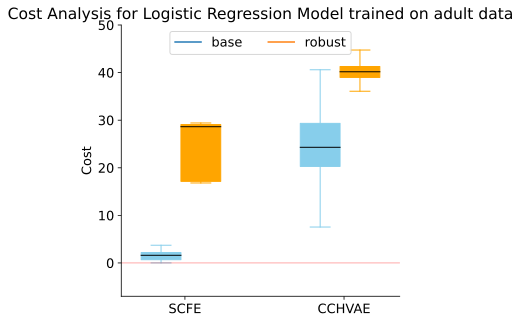

In [106]:
plt.rcParams.update({'font.size': 13})  # , 'font.weight': 'bold'})
# plt.rc('font', family='sans-serif')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color='black')
# plt.rc('font', family='sans-serif')


# inits
algos = ['scfe', 'cchvae'] # 'itg', 'sg005', 'shap', 'lime005', 'control'] #, 'pgmex', 'pgex']  # , 'gnnex', 'pgmex', 'pgex']

datasets =   ["adult"] #, "compas"]
bernoullis = ["0.03"] #, "0.1"]
variances =  ["0.05"] #, "0.1"]
model_name = "ann" #need change for different models

stability_notions = ["base", "robust"] #["stability2_diff_input", "stability2_diff_representation", "stability2_diff_output"]

for data_name in datasets:
    plt.figure(figsize=(5, 5))
    plot_names = ["base", "robust"]
    plot_cols = ["skyblue", "orange"] #, "orange"]
    plots = []
    tick_val= -0.3
    for stab_ind,stability_notion in enumerate(stability_notions):
#         df = None
        df = pd.read_csv(stability_notion + "_cost_{}.csv".format(data_name))

        df_sep = []

        for i, val in enumerate(algos):
            print("processing ..", val)
            df_sep.append(df[df["Method"] == val]["Cost"].to_numpy())

        
#         ## print statistics
#         for i, val in enumerate(df_sep):
#             print(f'Explanation method: {algos[i]}, Mean_1={np.mean(val):.3f}, median={np.median(df_sep[i]):.3f}')

        
        val = plt.boxplot(df_sep, positions=np.array(range(len(df_sep)))*2.0+tick_val, sym='', widths=0.5, patch_artist=True) 
        tick_val+=0.5
        plt.plot([], label=plot_names[stab_ind])
        print(plot_cols[stab_ind])
        set_box_color(val, plot_cols[stab_ind])
        
        
    #plt.legend(loc="center bottom")
    plt.legend(loc='upper center', ncol=2)
    plt.xticks(np.array(range(len(df_sep)))*2.0, ['SCFE', 'CCHVAE'])
    plt.ylim(-7, 50)
    plt.axhline(y=0, color='red', linewidth= 0.3)
    plt.ylabel("Cost")
    plt.title("Cost Analysis for Logistic Regression Model trained on {} data".format(data_name))
    plt.savefig(data_name+"_"+model_name+"_cost.pdf",  bbox_inches='tight')
    
        
        

In [92]:

testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model_robust, inputs, subset_size, decision_threshold=0)
print(inputs.shape)
print(inputs[0].reshape(1, -1))
distances_cchave_r = [cchvae.generate_counterfactuals(
                    query_instance= inputs[i].reshape(1, -1),
                    target_class= 1 ).item() for i in range(subset_size)]

print(epoch_adv(test_loader, model, delta[None,None,:,:]))

torch.Size([1200, 13])
tensor([[0.1370, 0.1511, 0.5333, 0.0000, 0.0000, 0.1939, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 0.0000, 1.0000]])


KeyboardInterrupt: 

In [ ]:
distances_cchave_r

In [ ]:
sum(distances_cchave)/len(distances_cchave)